In [3]:

import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,accuracy_score
from joblib import delayed, Parallel
from tqdm import tqdm
    # from sklearn.metrics import 
plt.rcParams['text.usetex'] = True
# df0 = pd.read_excel('CKD_agri_data.xls')


In [4]:
def RFClassifier(dfin, target, cols_to_drop, trees):
    df_clean = dfin.dropna(subset=target)
    X =df_clean.drop(columns=cols_to_drop)
    y =df_clean[target[0]]


    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y
    )

    clf = RandomForestClassifier(
        n_estimators=trees, 
        random_state=42, 
        class_weight='balanced'  
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
        
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    accuracy = report['accuracy']
    return accuracy


def RF_wrapper(tree):
    return RFClassifier(
        dfnum,
        ['ckd_code_sample_1'],
        ['ckd_code_sample_1', 'ckd__probable_sample_1', 'ckd_epi_sample_1'],
        trees=tree
    )


In [ ]:
dfnum = pd.read_csv('numeric_data_agri.csv')

# acc1 = RFClassifier(dfnum,
#             ['ckd_code_sample_1'],
#             ['ckd_code_sample_1', 'ckd__probable_sample_1', 'ckd_epi_sample_1' ],
#             trees=100)

<>:11: SyntaxWarning: invalid escape sequence '\#'
<>:11: SyntaxWarning: invalid escape sequence '\#'
C:\Users\aksha\AppData\Local\Temp\ipykernel_16372\2880068596.py:11: SyntaxWarning: invalid escape sequence '\#'
  plt.xlabel('\#Trees')
100%|██████████| 59/59 [00:00<00:00, 1309.64it/s]


Text(0, 0.5, 'Accuracy')

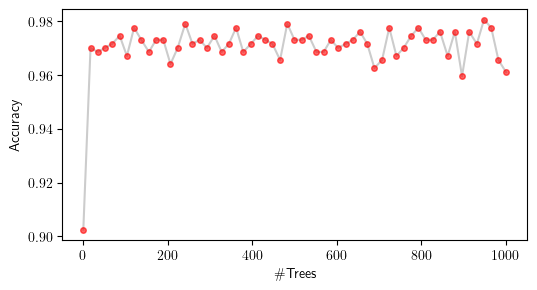

In [23]:
n_tree = np.linspace(1, 1000, 59, dtype=int)
accs = np.zeros_like(n_tree)


accuracies = Parallel(n_jobs=-1)(
    delayed(RF_wrapper)(tree) for tree in tqdm(n_tree)
)
plt.figure(figsize=(6, 3))
plt.plot(n_tree, accuracies, '-', color='grey', alpha=.4)
plt.plot(n_tree, accuracies, 'o', markersize=4, alpha=.6, c='red')
plt.xlabel('\#Trees')
plt.ylabel('Accuracy')